#### Best model till now - remove Outlier handling in sales column and keep it untouched (and apply Gradient Boosting)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
np.random.seed(22)
from numpy import mean
from numpy import std
from math import sqrt
from scipy.stats import shapiro

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, train_test_split
from sklearn.utils import resample, class_weight
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [3]:
def plot_bin_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['binary_accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train_data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
print(train_data.shape)
train_data.isnull().sum()

(8523, 12)


item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

In [7]:
test_data.isnull().sum()

item_identifier                 0
item_weight                   976
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  1606
outlet_location_type            0
outlet_type                     0
dtype: int64

In [8]:
train_data.nunique()

item_identifier              1559
item_weight                   415
item_fat_content                5
item_visibility              7880
item_type                      16
item_mrp                     5938
outlet_identifier              10
outlet_establishment_year       9
outlet_size                     3
outlet_location_type            3
outlet_type                     4
item_outlet_sales            3493
dtype: int64

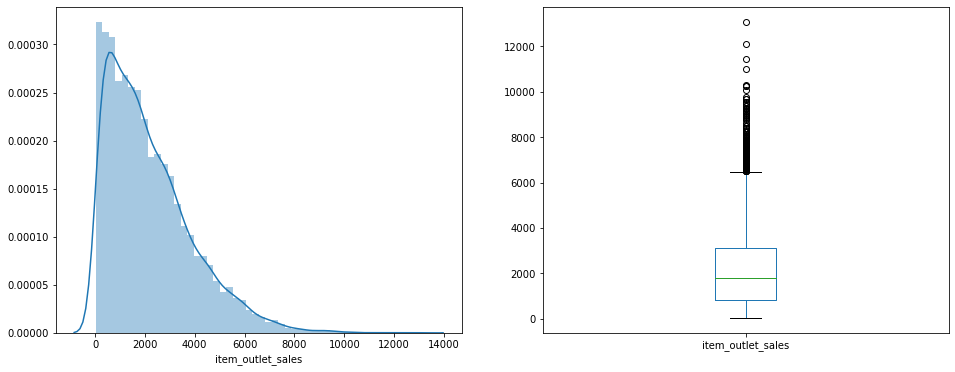

In [9]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_data["item_outlet_sales"]);

plt.subplot(122)
train_data["item_outlet_sales"].plot.box(figsize=(16, 6))
plt.show()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: item_type, dtype: int64


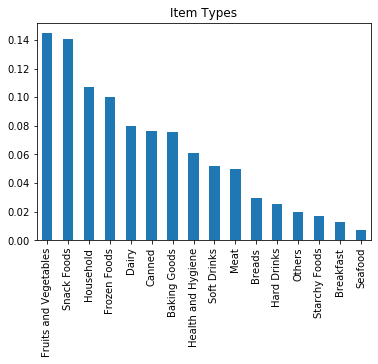

In [10]:
print(train_data["item_type"].value_counts())
train_data['item_type'].value_counts(normalize = True).plot.bar(title = 'Item Types')

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: outlet_type, dtype: int64


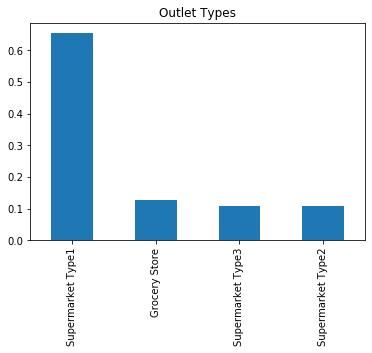

In [11]:
print(train_data["outlet_type"].value_counts())
train_data['outlet_type'].value_counts(normalize = True).plot.bar(title = 'Outlet Types')

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: outlet_location_type, dtype: int64


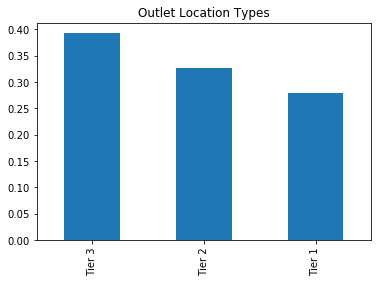

In [12]:
print(train_data["outlet_location_type"].value_counts())
train_data['outlet_location_type'].value_counts(normalize = True).plot.bar(title = 'Outlet Location Types')

Low Fat    5517
Regular    3006
Name: item_fat_content, dtype: int64


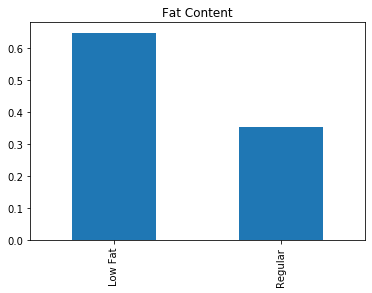

In [13]:
train_data['item_fat_content'] = train_data['item_fat_content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
test_data['item_fat_content'] = test_data['item_fat_content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

print(train_data["item_fat_content"].value_counts())
train_data['item_fat_content'].value_counts(normalize = True).plot.bar(title = 'Fat Content')

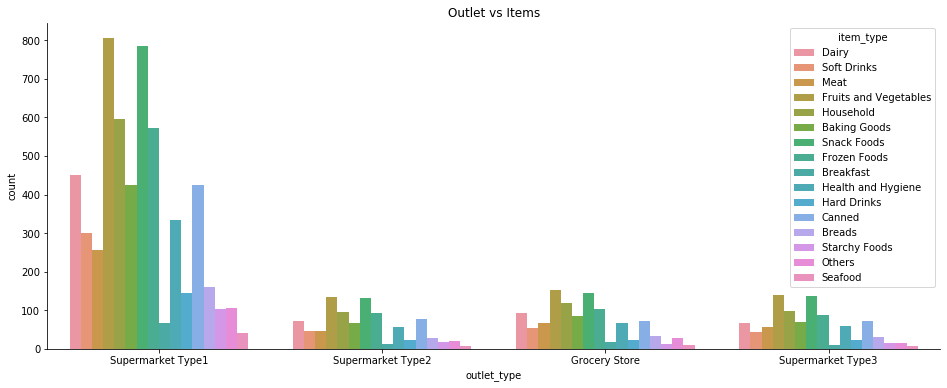

In [14]:
plt.figure(figsize = (16, 6))
sns.countplot(train_data["outlet_type"], hue = train_data["item_type"]).set_title("Outlet vs Items")
sns.despine()

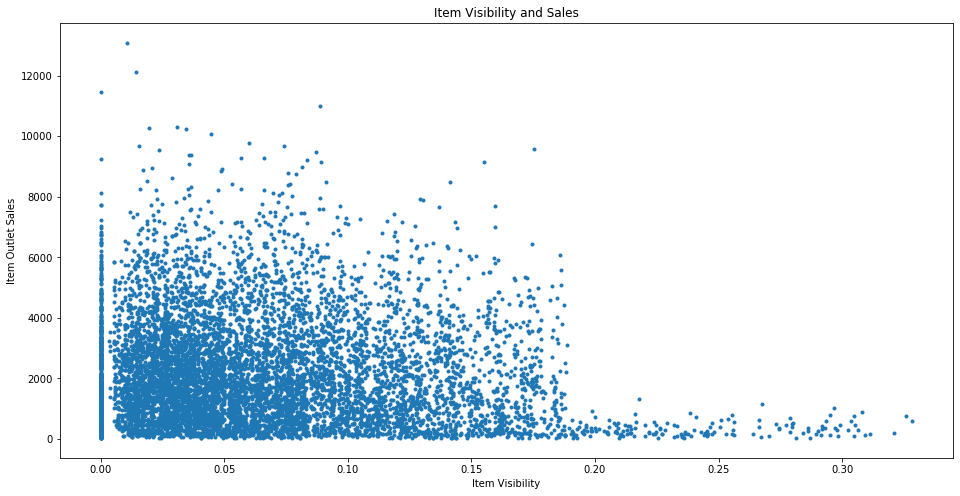

In [15]:
plt.figure(figsize = (16, 8))
plt.xlabel('Item Visibility')
plt.ylabel('Item Outlet Sales')
plt.title('Item Visibility and Sales')
plt.plot(train_data.item_visibility, train_data.item_outlet_sales, '.')
plt.show()

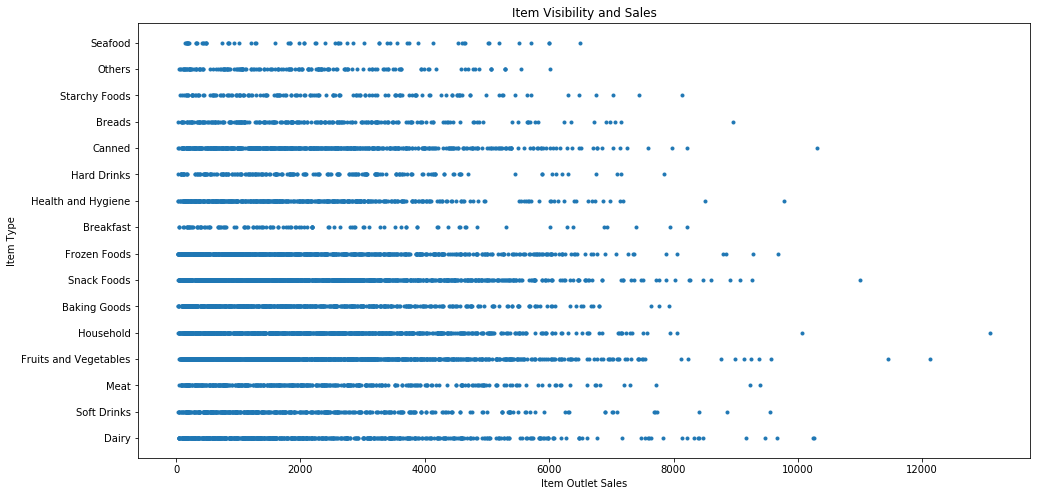

In [16]:
plt.figure(figsize = (16, 8))
plt.ylabel('Item Type')
plt.xlabel('Item Outlet Sales')
plt.title('Item Visibility and Sales')
plt.plot(train_data.item_outlet_sales, train_data['item_type'], '.')
plt.show()

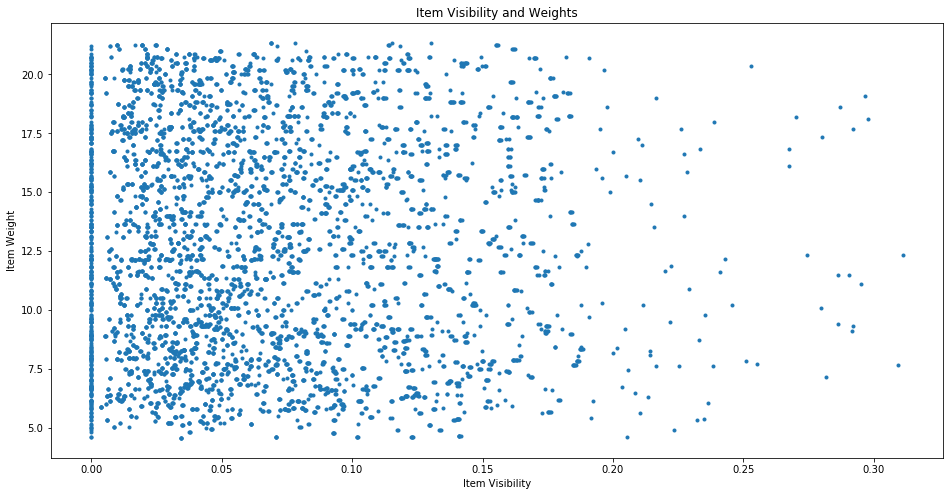

In [17]:
plt.figure(figsize = (16, 8))
plt.xlabel('Item Visibility')
plt.ylabel('Item Weight')
plt.title('Item Visibility and Weights')
plt.plot(train_data.item_visibility, train_data.item_weight, '.')
plt.show()

<Figure size 1152x576 with 0 Axes>

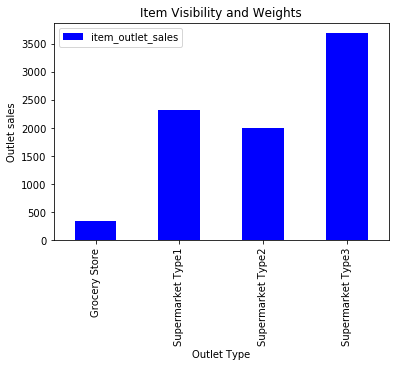

In [18]:
plt.figure(figsize = (16, 8))
outlet_type_sales = train_data.pivot_table(index = 'outlet_type', values = 'item_outlet_sales')
outlet_type_sales.plot(kind = 'bar', color = 'blue')
plt.xlabel('Outlet Type')
plt.ylabel('Outlet sales')
plt.title('Item Visibility and Weights')
plt.show()

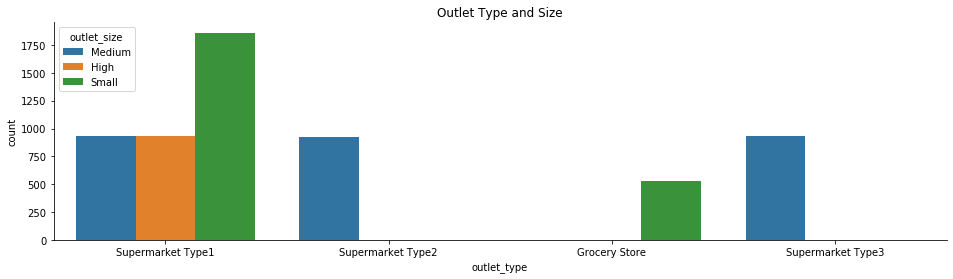

In [19]:
plt.figure(figsize = (16, 4))
sns.countplot(train_data["outlet_type"], hue = train_data["outlet_size"]).set_title("Outlet Type and Size")
sns.despine()

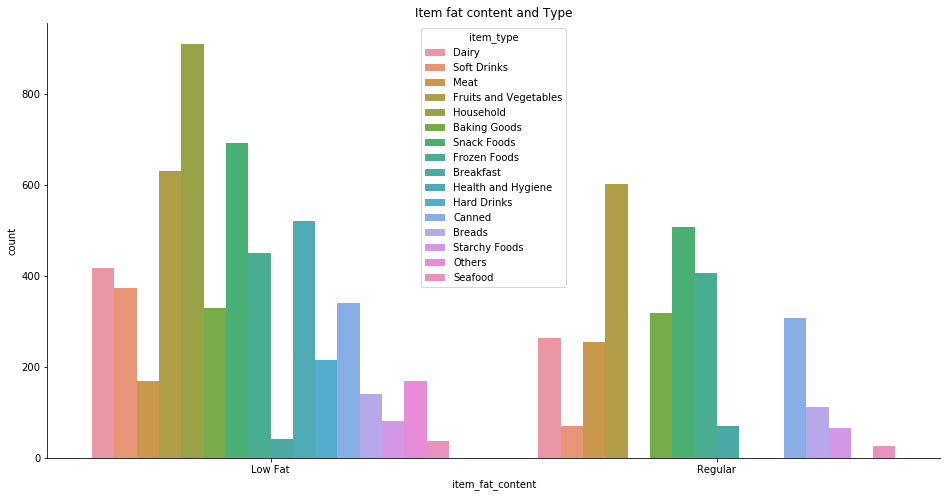

In [20]:
plt.figure(figsize = (16, 8))
sns.countplot(train_data["item_fat_content"], hue = train_data["item_type"]).set_title("Item fat content and Type")
sns.despine()

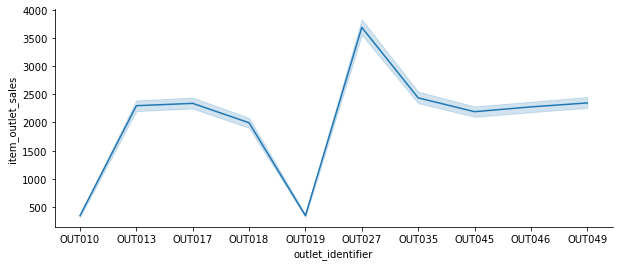

In [21]:
plt.figure(figsize = (10, 4))
sns.lineplot(data = train_data, x = 'outlet_identifier', y = 'item_outlet_sales')
sns.despine()

In [22]:
avg_outlet_sales = train_data.pivot_table(index = 'item_identifier', values = 'item_outlet_sales')

def train_sls_imp(data):
    item_id = data[0]
    sales = data[1]
    if sales != 0: return avg_outlet_sales['item_outlet_sales'][avg_outlet_sales.index == item_id].get(0)

train_data.loc[(train_data['item_outlet_sales'] > 8000), 'item_outlet_sales'] = train_data[['item_identifier', 'item_outlet_sales']].apply(train_sls_imp, axis = 1)

In [23]:
train_data['outlet_age'] = 2013 - train_data['outlet_establishment_year']
test_data['outlet_age'] = 2013 - test_data['outlet_establishment_year']

item_weights = train_data[['item_identifier', 'item_weight']].append(test_data[['item_identifier', 'item_weight']])
item_weights = item_weights.pivot_table(index = 'item_identifier', values = 'item_weight')

def train_weight_imp(data):
    item_id = data[0]
    weight = data[1]
    if pd.isnull(weight): return item_weights['item_weight'][item_weights.index == item_id]

def test_weight_imp(data):
    item_id = data[0]
    weight = data[1]
    if pd.isnull(weight): return item_weights['item_weight'][item_weights.index == item_id]
    
train_data.loc[(train_data['item_weight'].isnull()), 'item_weight'] = train_data[['item_identifier', 'item_weight']].apply(train_weight_imp, axis = 1).str.get(0)
test_data.loc[(test_data['item_weight'].isnull()), 'item_weight'] = test_data[['item_identifier', 'item_weight']].apply(test_weight_imp, axis = 1).str.get(0)

In [24]:
Visibility = train_data[['item_identifier', 'item_visibility']].append(test_data[['item_identifier', 'item_visibility']])
Visibility = Visibility.pivot_table(index = 'item_identifier', values = 'item_visibility')

def train_vis_imp(data):
    item_id = data[0]
    visibility = data[1]
    if visibility == 0: return Visibility['item_visibility'][Visibility.index == item_id]

def test_vis_imp(data):
    item_id = data[0]
    visibility = data[1]
    if visibility == 0: return Visibility['item_visibility'][Visibility.index == item_id]

train_data.loc[(train_data['item_visibility'] == 0), 'item_visibility'] = train_data[['item_identifier', 'item_visibility']].apply(train_vis_imp, axis = 1).str.get(0)
test_data.loc[(train_data['item_visibility'] == 0), 'item_visibility'] = test_data[['item_identifier', 'item_visibility']].apply(test_vis_imp, axis = 1).str.get(0)

In [25]:
Size = train_data[['outlet_type', 'outlet_size']].append(test_data[['outlet_type', 'outlet_size']])
Size = Size.pivot_table(index = 'outlet_type', values = 'outlet_size', aggfunc = lambda x: x.mode())

def train_size_imp(data):
    outlet_type = data[0]
    size = data[1]
    if pd.isnull(size): return Size['outlet_size'][Size.index == outlet_type]

def test_size_imp(data):
    outlet_type = data[0]
    size = data[1]
    if pd.isnull(size): return Size['outlet_size'][Size.index == outlet_type]

#train_data.loc[(train_data['outlet_identifier'] == 'OUT010'), 'outlet_size'] = 'Small'
#test_data.loc[(test_data['outlet_identifier'] == 'OUT010'), 'outlet_size'] = 'Small'

#train_data.loc[(train_data['outlet_size'].isnull()), 'outlet_size'] = 'Medium'
#test_data.loc[(test_data['outlet_size'].isnull()), 'outlet_size'] = 'Medium'

train_data.loc[(train_data['outlet_size'].isnull()), 'outlet_size'] = train_data[['outlet_type', 'outlet_size']].apply(train_size_imp, axis = 1).str.get(0)
test_data.loc[(test_data['outlet_size'].isnull()), 'outlet_size'] = test_data[['outlet_type', 'outlet_size']].apply(test_size_imp, axis = 1).str.get(0)

In [26]:
train_data['item_id'] = train_data['item_identifier'].apply(lambda x: 'Consumable' if x[0:2] in ['DR', 'FD'] else 'Non Consumable')
test_data['item_id'] = test_data['item_identifier'].apply(lambda x: 'Consumable' if x[0:2] in ['DR', 'FD'] else 'Non Consumable')

In [27]:
train_data['outlet_size'] = train_data['outlet_size'].replace({'High': 3, 'Medium': 2, 'Small': 1})
test_data['outlet_size'] = test_data['outlet_size'].replace({'High': 3, 'Medium': 2, 'Small': 1})
train_data['visibility'] = train_data['item_identifier'].apply(lambda x: Visibility['item_visibility'][Visibility.index == x][0])
test_data['visibility'] = test_data['item_identifier'].apply(lambda x: Visibility['item_visibility'][Visibility.index == x][0])
train_data['item_vis_mean_ratio'] = train_data['item_visibility']/train_data['visibility']
test_data['item_vis_mean_ratio'] = test_data['item_visibility']/test_data['visibility']
train_data.drop('visibility', axis = 1)
test_data.drop('visibility', axis = 1)
train_data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,outlet_age,item_id,visibility,item_vis_mean_ratio
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2,Tier 1,Supermarket Type1,3735.1380,14,Consumable,0.017235,0.931078
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2,Tier 3,Supermarket Type2,443.4228,4,Consumable,0.020653,0.933420
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2,Tier 1,Supermarket Type1,2097.2700,14,Consumable,0.017457,0.960069
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,1,Tier 3,Grocery Store,732.3800,15,Consumable,0.017834,1.000000
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,3,Tier 3,Supermarket Type1,994.7052,26,Non Consumable,0.009780,1.000000


# CATBOOST

In [28]:
# Dividing the data into test and train datasets

train_dataCB = train_data.drop(['item_identifier', 'outlet_establishment_year', 'outlet_identifier'], axis = 1)
X = train_dataCB.drop('item_outlet_sales', axis = 1).values
y = train_dataCB['item_outlet_sales'].values
train_dataCB.head()

,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,outlet_age,item_id,visibility,item_vis_mean_ratio
0,9.30,Low Fat,0.016047,Dairy,249.8092,2,Tier 1,Supermarket Type1,3735.1380,14,Consumable,0.017235,0.931078
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2,Tier 3,Supermarket Type2,443.4228,4,Consumable,0.020653,0.933420
2,17.50,Low Fat,0.016760,Meat,141.6180,2,Tier 1,Supermarket Type1,2097.2700,14,Consumable,0.017457,0.960069
3,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,1,Tier 3,Grocery Store,732.3800,15,Consumable,0.017834,1.000000
4,8.93,Low Fat,0.009780,Household,53.8614,3,Tier 3,Supermarket Type1,994.7052,26,Non Consumable,0.009780,1.000000


In [29]:
kfold, scores = KFold(n_splits = 10, shuffle = True, random_state = 0), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    modelCB = CatBoostRegressor(random_state = 27, max_depth = 6, n_estimators = 250, verbose = 50)
    modelCB.fit(X_train, y_train, cat_features = [1, 3, 5, 6, 7, 9])
    preds = modelCB.predict(X_test)
    score = sqrt(mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)

test_outlet_id = test_data['outlet_identifier'].values
test_item_id = test_data['item_identifier'].values

test_dataCB = test_data.drop(['item_identifier', 'outlet_establishment_year', 'outlet_identifier'], axis = 1)

Y_Pred = modelCB.predict(test_dataCB)

submission_df = pd.DataFrame({
                  "Item_Identifier": pd.Series(test_item_id),
                  "Outlet_Identifier": pd.Series(test_outlet_id),
                  "Item_Outlet_Sales": pd.Series(Y_Pred)})
submission_df.to_csv('submission_1_CB.csv', index = False)

print("Average RMSE (Validation): ", sum(scores)/len(scores))
print('\nActual Test Data RMSE: ', sqrt(mean_squared_error(y_test, preds)))

Learning rate set to 0.160864
0:	learn: 1495.7791728	total: 108ms	remaining: 26.9s
50:	learn: 1004.7513041	total: 775ms	remaining: 3.02s
100:	learn: 975.9680117	total: 1.54s	remaining: 2.28s
150:	learn: 945.8963802	total: 2.38s	remaining: 1.56s
200:	learn: 918.5231741	total: 3.29s	remaining: 802ms
249:	learn: 895.6997424	total: 4.2s	remaining: 0us
1062.0964998086909
Learning rate set to 0.160864
0:	learn: 1490.4849833	total: 18.6ms	remaining: 4.63s
50:	learn: 1005.2548715	total: 819ms	remaining: 3.2s
100:	learn: 977.5337941	total: 1.81s	remaining: 2.66s
150:	learn: 945.9103119	total: 2.67s	remaining: 1.75s
200:	learn: 921.9568597	total: 3.61s	remaining: 880ms
249:	learn: 898.3922712	total: 4.49s	remaining: 0us
1071.6450341560028
Learning rate set to 0.160864
0:	learn: 1490.7666184	total: 21.2ms	remaining: 5.29s
50:	learn: 1002.5642181	total: 759ms	remaining: 2.96s
100:	learn: 972.5050698	total: 1.52s	remaining: 2.24s
150:	learn: 944.0114665	total: 2.71s	remaining: 1.78s
200:	learn: 918

# GRADIENT BOOSTING

In [30]:
le = LabelEncoder()
train_data['outlet'] = le.fit_transform(train_data['outlet_identifier'])
test_data['outlet'] = le.fit_transform(test_data['outlet_identifier'])
train_data = train_data.drop(['item_identifier', 'outlet_establishment_year', 'outlet_identifier'], axis = 1)
test_data = test_data.drop(['item_identifier', 'outlet_establishment_year', 'outlet_identifier'], axis = 1)

In [31]:
columns = ['item_fat_content', 'item_type', 'outlet_location_type', 'outlet_type', 'item_id']
train_data = pd.get_dummies(train_data, columns = columns)
test_data = pd.get_dummies(test_data, columns = columns)

In [32]:
train_data.head()

,item_weight,item_visibility,item_mrp,outlet_size,item_outlet_sales,outlet_age,visibility,item_vis_mean_ratio,outlet,item_fat_content_Low Fat,...,item_type_Starchy Foods,outlet_location_type_Tier 1,outlet_location_type_Tier 2,outlet_location_type_Tier 3,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3,item_id_Consumable,item_id_Non Consumable
0,9.30,0.016047,249.8092,2,3735.1380,14,0.017235,0.931078,9,1,...,0,1,0,0,0,1,0,0,1,0
1,5.92,0.019278,48.2692,2,443.4228,4,0.020653,0.933420,3,0,...,0,0,0,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,2,2097.2700,14,0.017457,0.960069,9,1,...,0,1,0,0,0,1,0,0,1,0
3,19.20,0.017834,182.0950,1,732.3800,15,0.017834,1.000000,0,0,...,0,0,0,1,1,0,0,0,1,0
4,8.93,0.009780,53.8614,3,994.7052,26,0.009780,1.000000,1,1,...,0,0,0,1,0,1,0,0,0,1


In [33]:
test_data.head()

,item_weight,item_visibility,item_mrp,outlet_size,outlet_age,visibility,item_vis_mean_ratio,outlet,item_fat_content_Low Fat,item_fat_content_Regular,...,item_type_Starchy Foods,outlet_location_type_Tier 1,outlet_location_type_Tier 2,outlet_location_type_Tier 3,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3,item_id_Consumable,item_id_Non Consumable
0,20.750,0.007565,107.8622,2,14,0.007350,1.029192,9,1,0,...,0,1,0,0,0,1,0,0,1,0
1,8.300,0.038428,87.3198,1,6,0.033997,1.130311,2,0,1,...,0,0,1,0,0,1,0,0,1,0
2,14.600,0.099575,241.7538,1,15,0.057385,1.735215,0,1,0,...,0,0,0,1,1,0,0,0,0,1
3,7.315,0.015388,155.0340,1,6,0.011914,1.291577,2,1,0,...,0,0,1,0,0,1,0,0,1,0
4,13.600,0.118599,234.2300,2,28,0.129218,0.917824,5,0,1,...,0,0,0,1,0,0,0,1,1,0


In [34]:
# Dividing the data into test and train datasets
X = train_data.drop('item_outlet_sales', axis = 1).values
y = train_data['item_outlet_sales'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [35]:
model = GradientBoostingRegressor(n_estimators = 50)
cv = RepeatedKFold(n_splits = 6, n_repeats = 4, random_state = 0)
n_scores = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1, error_score = 'raise')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean Squared Error (Validation Gradient Boosting): ', sqrt(mean_squared_error(y_test, y_pred)))
Y_Pred = model.predict(test_data)

Mean Squared Error (Validation Gradient Boosting):  1062.986189227247


In [36]:
submission_df = pd.DataFrame({
                  "Item_Identifier": pd.Series(test_item_id),
                  "Outlet_Identifier": pd.Series(test_outlet_id),
                  "Item_Outlet_Sales": pd.Series(Y_Pred)})
submission_df.to_csv('submission_1_GB.csv', index = False)

# XGBOOST

In [37]:
modelXGB = XGBRegressor(objective='reg:squarederror', booster = 'gblinear', eval_metric = 'rmse')
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
n_scores = cross_val_score(modelXGB, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1, error_score = 'raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
modelXGB.fit(X_train, y_train)

MAE: -809.770 (21.599)


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eval_metric='rmse',
             gamma=None, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.5,
             max_delta_step=None, max_depth=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

In [38]:
y_pred = modelXGB.predict(X_test)
print('Root Mean Squared Error (Validation XGBOOST): ', sqrt(mean_squared_error(y_test, y_pred)))
Y_Pred = modelXGB.predict(test_data.values)

Root Mean Squared Error (Validation XGBOOST):  1104.500307118453


In [39]:
submission_df = pd.DataFrame({
                  "Item_Identifier": pd.Series(test_item_id),
                  "Outlet_Identifier": pd.Series(test_outlet_id),
                  "Item_Outlet_Sales": pd.Series(Y_Pred)})
submission_df.to_csv('submission_1_XGB.csv', index = False)